# Deep Learning on Graph Data:

In this presentation we use Tensorflow to detect fraudulent graph structures. 

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it
import random

In [2]:
# create new session if we need it
sess = tf.Session()

In [3]:
def generate_graphs(n):
    # Code to generate n random graphs
    
    graphset = []
    
    for i in range(n):

        # Assigning number of nodes randomly between 1-200
        n_nodes = random.randint(1,200)
        
        # Modelling the resource allocation with Normal Distrib - mean: m, and stddev = s
        p = 0.3       
        m = 20
        s = 0.25

        '''sess.run(tf.global_variables_initializer())'''
        G_rand = nx.duplication_divergence_graph(n_nodes, p, 1)

        # add tf Pagerank variables to each node - this could be required for Tensorflow optimizations
        '''for node, data in G_rand.nodes_iter(data=True):
            data['PageRank'] = tf.Variable(tf.random_normal([1,1], mean = m, stddev=s))
'''
        graphset.append(G_rand)
    
    return graphset

In [4]:
def displayGraph(graph):
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos)
    nx.draw_networkx_edges(graph, pos, arrows=True)
    nx.draw_networkx_labels(graph,pos)
    plt.title('Graphs generated')
    plt.show()

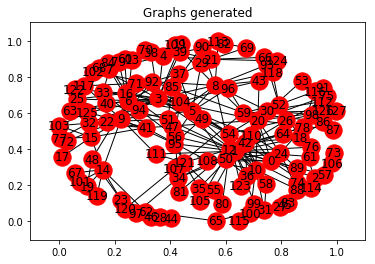

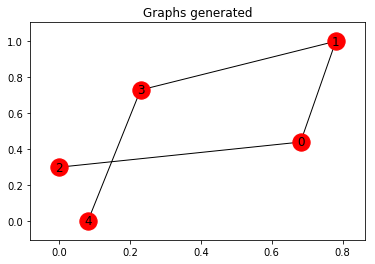

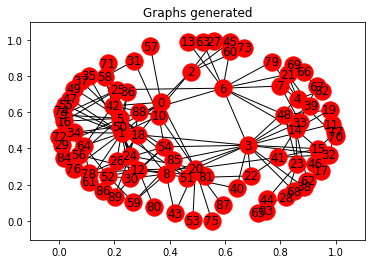

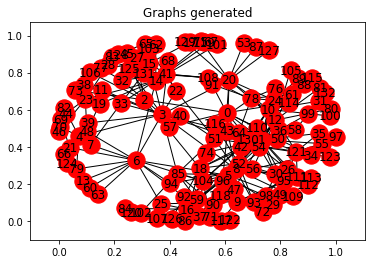

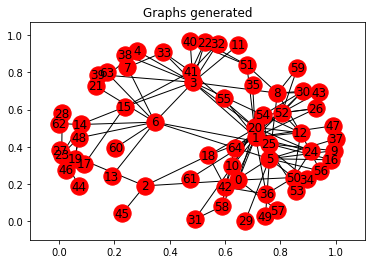

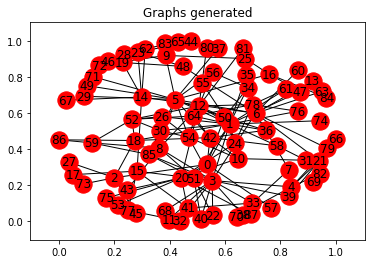

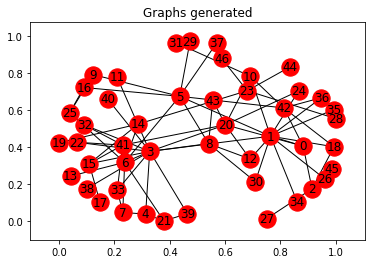

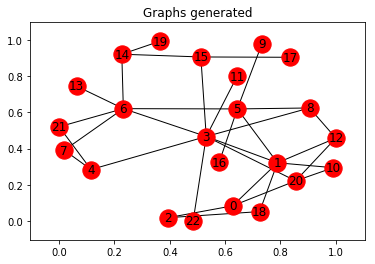

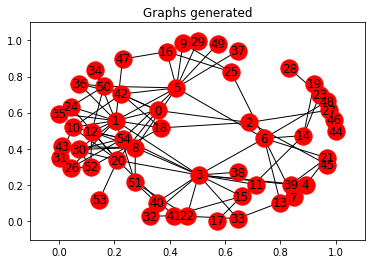

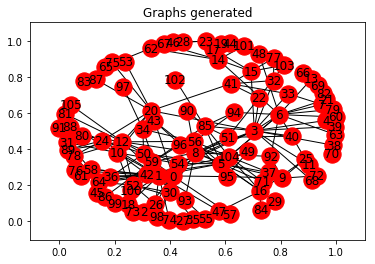

In [5]:
# Generating a set of 30 graphs with varying number of nodes (1-200)

n = 10
graphset = generate_graphs(n)

# Printing the graphs:
for graph in graphset:
    displayGraph(graph)

In [6]:
def pageRank_allocation(G):
    
    # Calculate PageRank here
    pr = nx.pagerank(G)
    
    # Assign PageRank values here
    for i in G:
        node = G.node[i]
        page_rank_value = pr[i]
        node['PageRank'] = tf.constant(page_rank_value)

In [ ]:
pageRank_allocation(graphset[1])

In [ ]:
pr

In [7]:
# After crosschecking for one graph doing for all the graphs
count = 0

for i in range(len(graphset)):
    print 'Allocating Pagerank score for Graph:', i
    pageRank_allocation(graphset[i])

Allocating Pagerank score for Graph: 0
Allocating Pagerank score for Graph: 1
Allocating Pagerank score for Graph: 2
Allocating Pagerank score for Graph: 3
Allocating Pagerank score for Graph: 4
Allocating Pagerank score for Graph: 5
Allocating Pagerank score for Graph: 6
Allocating Pagerank score for Graph: 7
Allocating Pagerank score for Graph: 8
Allocating Pagerank score for Graph: 9


In [9]:
G = graphset[0]

for i in G:
    print i, sess.run(G.node[i]['PageRank'])

0 0.0179241
1 0.0403278
2 0.0163773
3 0.0330368
4 0.0139881
5 0.0275778
6 0.0289102
7 0.00671815
8 0.0240535
9 0.0135362
10 0.0155622
11 0.00282394
12 0.025467
13 0.00292692
14 0.0208706
15 0.0132203
16 0.0129999
17 0.00304454
18 0.0134995
19 0.0055839
20 0.0225549
21 0.015034
22 0.00787146
23 0.0143781
24 0.0126846
25 0.00641179
26 0.00925583
27 0.00349176
28 0.00622706
29 0.00263717
30 0.0108283
31 0.00736422
32 0.00656978
33 0.00638831
34 0.00958858
35 0.00420003
36 0.00566516
37 0.00574233
38 0.00282394
39 0.00495398
40 0.00436604
41 0.0136743
42 0.0140655
43 0.00609174
44 0.00361597
45 0.00349176
46 0.00361597
47 0.00450344
48 0.00774398
49 0.004188
50 0.0106528
51 0.0108838
52 0.016188
53 0.00291452
54 0.0129278
55 0.00420003
56 0.0105759
57 0.00286494
58 0.00624254
59 0.0138395
60 0.00292692
61 0.00600177
62 0.00921622
63 0.00292692
64 0.00733633
65 0.00748186
66 0.00330191
67 0.00338957
68 0.00282394
69 0.00566552
70 0.0031533
71 0.00762786
72 0.00281532
73 0.00349176
74 0.0026

In [ ]:
# At this stage you have a list of Graphs containing random nodes from 1-200
# Each node has a tensorFlow constant value attached to it signifying its PageRank score